In [166]:
import ee
import geemap

# Initialize Earth Engine
ee.Initialize()

In [167]:
# Define the location of interest
station = ee.Geometry.Point(-76.586801, 42.554409)

other = ee.Geometry.Point(-76.583118, 42.556994)

# 42.554409, -76.586801

Map = geemap.Map()
Map.addLayer(station)
Map.addLayer(other)

# Center the map on the station point with a specified zoom level
Map.centerObject(station, 16)
Map

Map(center=[42.55440900000001, -76.586801], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

In [168]:
# Define the date range of interest
start_date = '2020-07-28'
end_date = '2020-08-02'

# 7/30/2020

# Define the Landsat 8 Surface Reflectance collection
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

# Filter the collection based on location and date
filtered_collection = collection.filterBounds(station).filterDate(start_date, end_date)

# Sort the collection by cloud cover in ascending order
sorted_collection = filtered_collection.sort('CLOUD_COVER')

# Select the least cloudy image from the sorted collection
least_cloudy_image = ee.Image(sorted_collection.first())

# Apply the cloud mask
cloud_mask = least_cloudy_image.select('pixel_qa').bitwiseAnd(int('0000000010000000', 2)).eq(0)

# Apply the cloud mask to the image
masked_image = least_cloudy_image.updateMask(cloud_mask)

In [169]:
# Display the image on the map
Map = geemap.Map()
Map.addLayer(least_cloudy_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Least Cloudy Image')
Map.addLayer(station)
Map.addLayer(other)
Map.centerObject(station, 16)
Map.addLayerControl()
Map

Map(center=[42.55440900000001, -76.586801], controls=(WidgetControl(options=['position', 'transparent_bg'], wi…

In [178]:
# Get the mean reflectance values from the 8 cells around the station point per band
band_values = masked_image.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']) \
    .reduceRegion(reducer=ee.Reducer.mean(),
                  geometry=station.buffer(120),
                  scale=30)

# Convert the band values to a list of float values
band_values = masked_image.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']) \
    .reduceRegion(reducer=ee.Reducer.mean(),
                  geometry=station.buffer(120),
                  scale=30)

# Convert the band values to a list of float values
band_values_list = [float(band_values.get(band).getInfo()) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']]

In [179]:
# Define the bands of interest... bands 1-7 
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

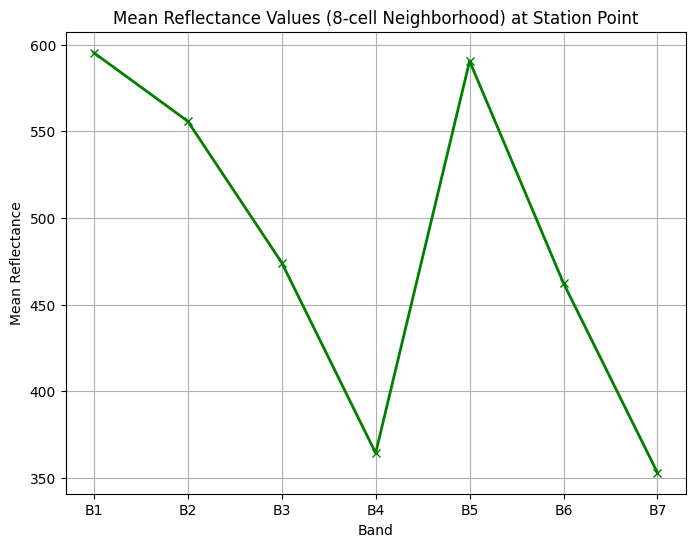

In [180]:
# Plot the mean reflectance values per band as a line graph
plt.figure(figsize=(8, 6))
plt.plot(bands, band_values_list, marker='x', color='green', linestyle='-', linewidth=2)
plt.xlabel('Band')
plt.ylabel('Mean Reflectance')
plt.title('Mean Reflectance Values (8-cell Neighborhood) at Station Point')
plt.grid(True)
plt.show()

In [181]:
# Get the mean reflectance values from the 8 cells around the other point per band
other_band_values = masked_image.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']) \
    .reduceRegion(reducer=ee.Reducer.mean(),
                  geometry=other.buffer(120),
                  scale=30)

# Convert the band values to lists of float values
other_band_values_list = [float(other_band_values.get(band).getInfo()) for band in ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']]

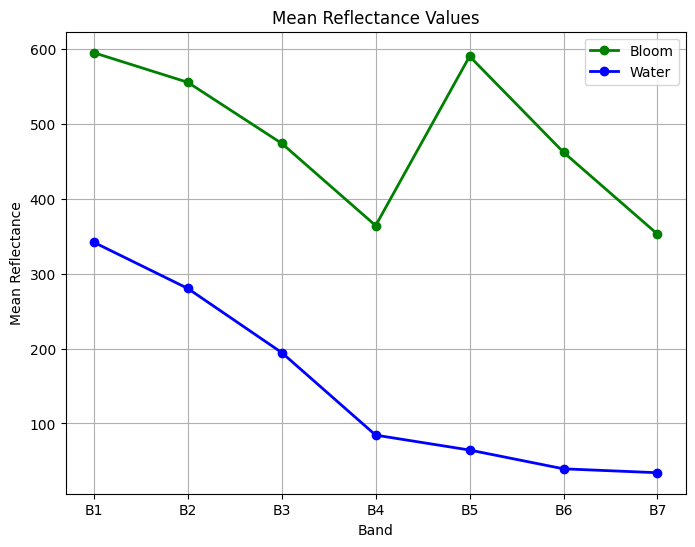

In [183]:
# Plot the mean reflectance values per band, at 'station' (algae) and 'other' (water)
plt.figure(figsize=(8, 6))
plt.plot(bands, station_band_values_list, marker='o', color='green', linestyle='-', linewidth=2, label='Bloom')
plt.plot(bands, other_band_values_list, marker='o', color='blue', linestyle='-', linewidth=2, label='Water')
plt.xlabel('Band')
plt.ylabel('Mean Reflectance')
plt.title('Mean Reflectance Values')
plt.legend()
plt.grid(True)
plt.show()


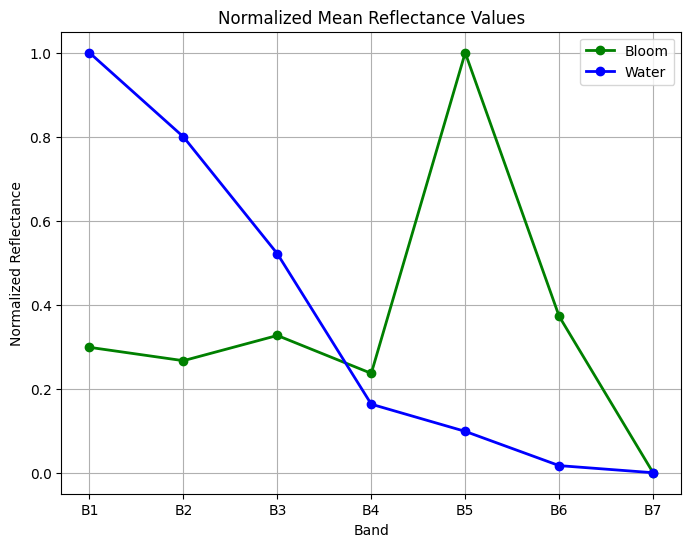

In [187]:
# Normalize the reflectance values
station_band_values_norm = (station_band_values_list - np.min(station_band_values_list)) / (np.max(station_band_values_list) - np.min(station_band_values_list))
other_band_values_norm = (other_band_values_list - np.min(other_band_values_list)) / (np.max(other_band_values_list) - np.min(other_band_values_list))

# Define the bands of interest
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Plot the mean reflectance values per band as a line graph
plt.figure(figsize=(8, 6))
plt.plot(bands, station_band_values_norm, marker='o', color='green', linestyle='-', linewidth=2, label='Bloom')
plt.plot(bands, other_band_values_norm, marker='o', color='blue', linestyle='-', linewidth=2, label='Water')
plt.xlabel('Band')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Mean Reflectance Values')
plt.legend()
plt.grid(True)
plt.show()

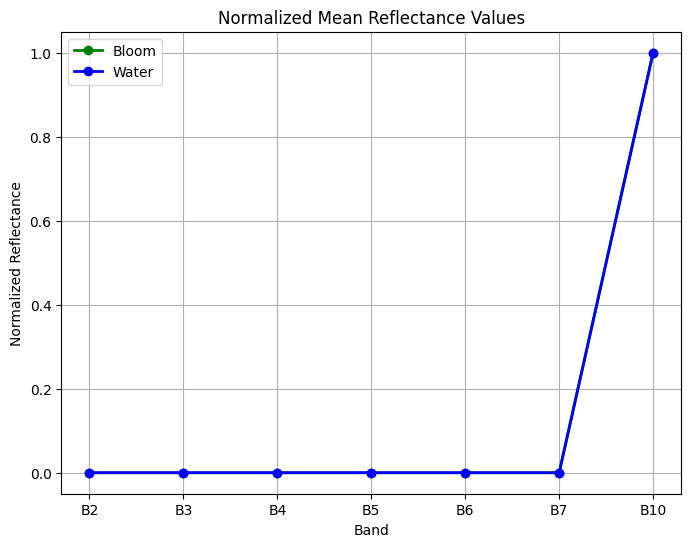

In [188]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

# Initialize Earth Engine
ee.Initialize()

# Define the date range of interest
start_date = '2020-08-25'
end_date = '2020-08-31'

# Define the function to mask Landsat 8 surface reflectance images
def maskL8sr(image):
    qaMask = image.select('pixel_qa').bitwiseAnd(int('0000000010000000', 2)).eq(0)
    saturationMask = image.select('sr_aerosol').lt(1000)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7']).multiply(0.0000275).add(-0.2)
    thermalBands = image.select('B10').multiply(0.1)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

# Define the Landsat 8 Surface Reflectance collection
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(station) \
    .filterDate(start_date, end_date) \
    .sort('CLOUD_COVER') \
    .map(maskL8sr)

# Select the least cloudy image from the filtered collection
least_cloudy_image = ee.Image(collection.first())

# Get the mean reflectance values from the 8 cells around the station point per band
station_band_values = least_cloudy_image.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10']) \
    .reduceRegion(reducer=ee.Reducer.mean(),
                  geometry=station.buffer(120),
                  scale=30)

# Get the mean reflectance values from the 8 cells around the other point per band
other_band_values = least_cloudy_image.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10']) \
    .reduceRegion(reducer=ee.Reducer.mean(),
                  geometry=other.buffer(120),
                  scale=30)

# Convert the band values to lists of float values
station_band_values_list = [float(station_band_values.get(band).getInfo()) for band in ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10']]
other_band_values_list = [float(other_band_values.get(band).getInfo()) for band in ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10']]

# Normalize the reflectance values
station_band_values_norm = (station_band_values_list - np.min(station_band_values_list)) / (np.max(station_band_values_list) - np.min(station_band_values_list))
other_band_values_norm = (other_band_values_list - np.min(other_band_values_list)) / (np.max(other_band_values_list) - np.min(other_band_values_list))

# Define the bands of interest
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10']

# Plot the mean reflectance values per band as a line graph
plt.figure(figsize=(8, 6))
plt.plot(bands, station_band_values_norm, marker='o', color='green', linestyle='-', linewidth=2, label='Bloom')
plt.plot(bands, other_band_values_norm, marker='o', color='blue', linestyle='-', linewidth=2, label='Water')
plt.xlabel('Band')
plt.ylabel('Normalized Reflectance')
plt.title('Normalized Mean Reflectance Values')
plt.legend()
plt.grid(True)
plt.show()